In [ ]:
import pandas as pd
distance = pd.read_json("analysis_5/distance.json")

print(distance)

In [ ]:
import pandas as pd
structure = pd.read_json("analysis_5/structure.json")

print(structure)

In [ ]:

import pandas as pd
assortativity = pd.read_json("analysis_5/assortativity.json")

print(assortativity)

In [ ]:

import pandas as pd
centrality = pd.read_json("analysis_5/centrality.json")

print(centrality)

In [ ]:
import pandas as pd

# Metodo 1: Usando l'index del DataFrame
df = pd.DataFrame({
    'Niche': [453, 4669, 0.0228],
    'Almost-niche': [14892, 439100, 0.0020],
    'Mixed': [15345, 83156, 0.0004]
}, index=['Nodes', 'Edges', 'Density'])  # <-- Nomi delle righe come index

# Converti con index=True (default)
latex_table = df.to_latex(
    caption='Structural properties',
    label='tab:structure',
    float_format="%.4f"
)
print(latex_table)

In [ ]:
import json
import os

import networkx as nx
with open("niche_graph.json") as f:
    graph_dict = json.load(f)

niche_graph = nx.node_link_graph(graph_dict)

with open("almost_niche_graph.json") as f:
    graph_dict = json.load(f)

almost_niche_graph = nx.node_link_graph(graph_dict)

with open("mixed_graph.json") as f:
    graph_dict = json.load(f)

mixed_graph = nx.node_link_graph(graph_dict)

In [ ]:
from networkx.algorithms import bipartite

# 1. Prendi i gradi dei nodi originali (fondamentale per il benchmark)
top_nodes = [n for n, d in mixed_graph.nodes(data=True) if d['bipartite'] == 1]
deg_sequence = [d for n, d in mixed_graph.degree(top_nodes)]

# 2. Genera un grafo bipartito casuale con la stessa densità (Modello Erdos-Renyi)
# n = num_star, m = num_emergenti, p = probabilità di arco (densità)
n = len(top_nodes)
m = mixed_graph.number_of_nodes() - n
p = mixed_graph.number_of_edges() / (n * m)

G_random = bipartite.random_graph(n, m, p)

# 3. Calcola il clustering sul grafo random e confronta
random_clust = bipartite.clustering(G_random)
avg_random_clust = sum(random_clust.values()) / len(random_clust)

print(f"Reale: 0.0238, Casuale: {avg_random_clust}")

In [5]:
import networkx as nx
import networkit as nk
import numpy as np
# 1. Genera il benchmark BIPARTITO reale con NetworkX
n = 453
m = 14892
p = 0.0004
nxbip = nx.bipartite.random_graph(n, m, p)

# 2. Converti in NetworKit
G_rand = nk.nxadapter.nx2nk(nxbip)

# 3. Calcola l'Average Path Length (con campionamento per velocità)
# Invece di EffectiveDiameter, usa l'approssimazione della distanza media
dist_alg = nk.distance.APSP(G_rand)
dist_alg.run()
avg_path_rand = dist_alg.getDistances(asarray=True)
valid_distances = avg_path_rand[avg_path_rand > 0]
valid_distances = valid_distances[valid_distances < G_rand.numberOfNodes()]
average_path_length = np.mean(valid_distances)
print(f"ASP del Benchmark Bipartito: {average_path_length}")

ASP del Benchmark Bipartito: 7.030791838966542


In [ ]:
import pandas as pd
import math
import numpy as np

degree_niche = float(np.mean([d for n, d in niche_graph.degree()]))
degree_almost__niche = float(np.mean([d for n, d in almost_niche_graph.degree()]))
nodes_niche = 453
nodes_almost = 14892
nodes_mixed = 15345


# Metodo 1: Usando l'index del DataFrame
df = pd.DataFrame({
    'Niche': [round(2.56384,4), round(0.118710, 4)],
    'Niche benchmark': [math.log(nodes_niche)/math.log(degree_niche),degree_niche/nodes_niche],
    'Almost-niche': [round(3.098455,4), round(0.245336,4)],
    'Almost-niche benchmark' : [math.log(nodes_almost)/math.log(degree_almost__niche),degree_almost__niche/nodes_almost],
    'Mixed': [round(3.754041,4), round(0.023887,4)],
    'Mixed benchmark':[round(avg_path_rand,4), round(avg_random_clust,4)]
}, index=['Average SP', 'Clustering Coefficient'])  # <-- Nomi delle righe come index

# Converti con index=True (default)
latex_table = df.to_latex(
    caption='Structural properties',
    label='tab:structure',
    float_format="%.4f"
)
print(latex_table)

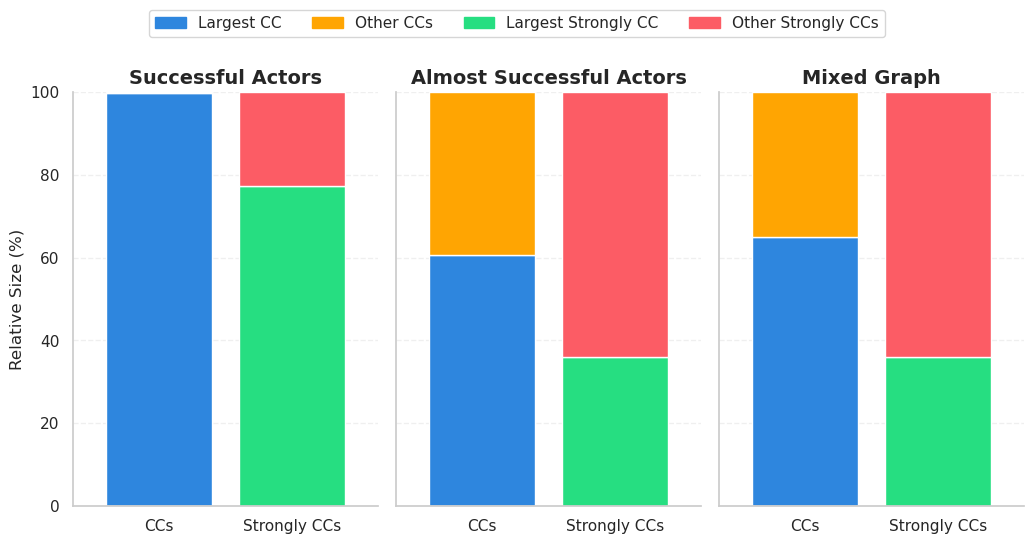

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Creazione dei dati
data = {
    'Dataset': ['Successful Actors', 'Successful Actors',
                'Successful Actors', 'Successful Actors',
                'Almost Successful Actors', 'Almost Successful Actors',
                'Almost Successful Actors', 'Almost Successful Actors',
                'Mixed Graph', 'Mixed Graph',
                'Mixed Graph', 'Mixed Graph'],
    'Sottogruppo': ['CCs', 'CCs', 'Strongly CCs', 'Strongly CCs',
                    'CCs', 'CCs', 'Strongly CCs', 'Strongly CCs',
                    'CCs', 'CCs', 'Strongly CCs', 'Strongly CCs'],
    'Attributo': ['Largest CC', 'Other CCs',
                  'Largest Strongly CC', 'Other Strongly CCs',
                  'Largest CC', 'Other CCs',
                  'Largest Strongly CC', 'Other Strongly CCs',
                  'Largest CC', 'Other CCs',
                  'Largest Strongly CC', 'Other Strongly CCs'],
    'Valore': [99.8, 0.2, 77.3, 22.7,    # Successful Actors
               60.7, 39.3, 35.9, 64.1,    # Almost Successful Actors
               65, 35, 35.9, 64.1]        # Mixed Graph
}

df = pd.DataFrame(data)

# 2. Colori molto distinti
colors = ['#2E86DE',  # Blu brillante - Largest CC
          '#FFA502',  # Arancione - Other CCs
          '#26DE81',  # Verde brillante - Largest Strongly CC
          '#FC5C65']  # Rosso corallo - Other Strongly CCs

# 3. Impostazione del layout con FacetGrid
g = sns.FacetGrid(df, col="Dataset", height=5, aspect=0.7)

# 4. Funzione per creare le barre impilate
def stacked_bar(data, **kwargs):
    pivot = data.pivot(index='Sottogruppo', columns='Attributo', values='Valore')
    column_order = ['Largest CC', 'Other CCs',
                    'Largest Strongly CC', 'Other Strongly CCs']
    pivot = pivot[[col for col in column_order if col in pivot.columns]]
    pivot.plot(kind='bar', stacked=True, ax=plt.gca(),
               color=colors, width=0.8, legend=False)

g.map_dataframe(stacked_bar)

# 5. Pulizia estetica
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

g.set_axis_labels("", "Relative Size (%)")
g.set_titles("{col_name}", size=14, weight='bold')

# 6. Aggiunta legenda centralizzata
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(4)]
labels = ['Largest CC', 'Other CCs', 'Largest Strongly CC', 'Other Strongly CCs']
g.figure.legend(handles, labels, loc='upper center', ncol=4,
                bbox_to_anchor=(0.5, 1.1), frameon=True, fontsize=11)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Spazio per la legenda
plt.savefig("fragmentation_plot.svg", bbox_inches='tight')
plt.show()

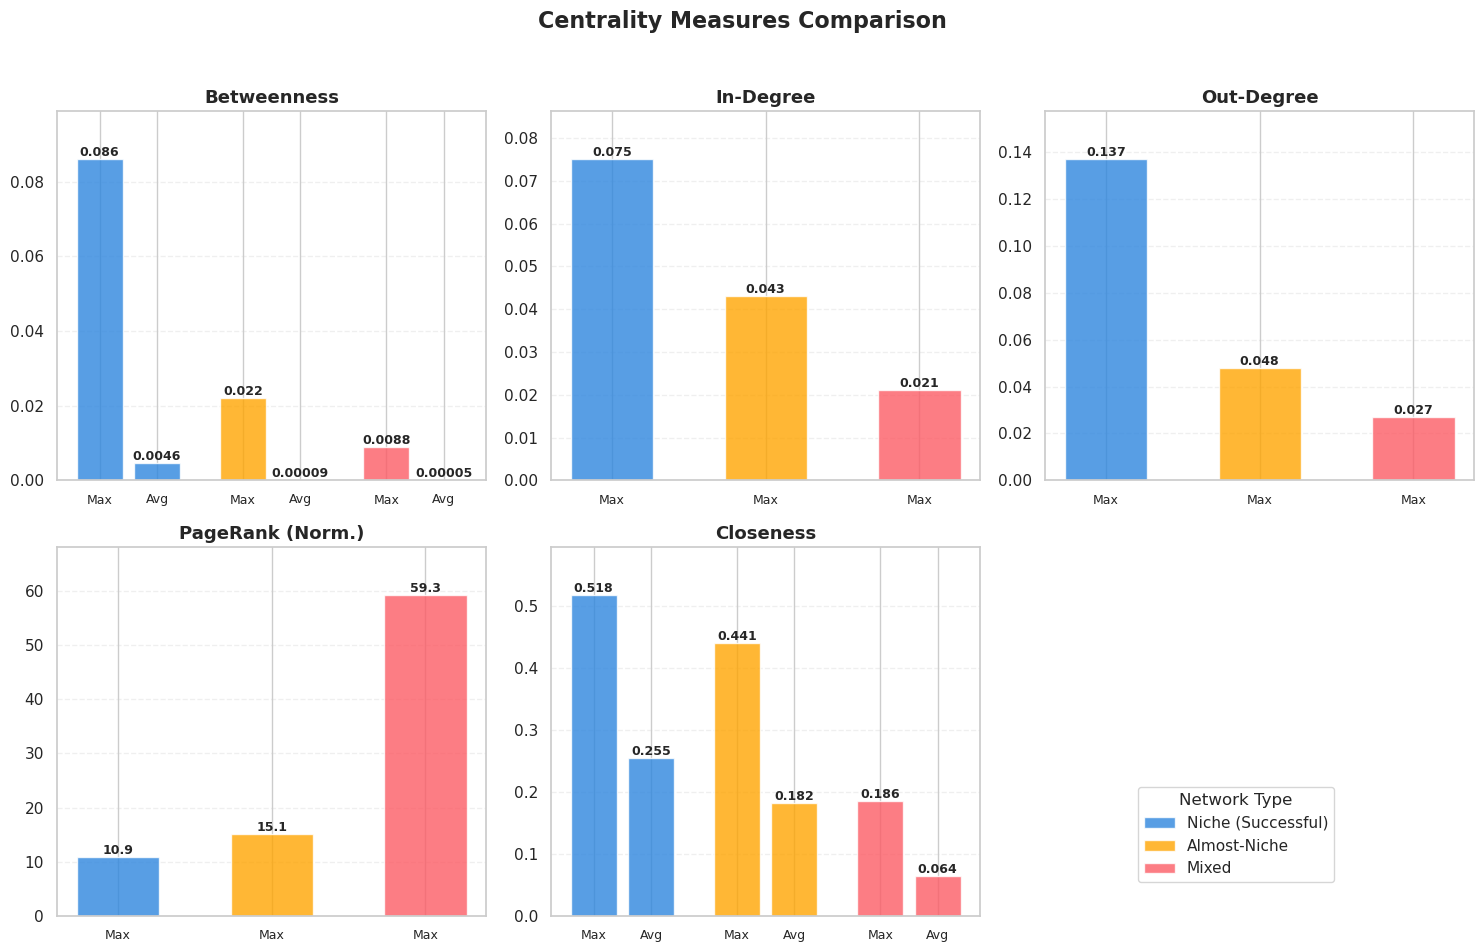

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Creazione del DataFrame
data = {
    # 5 metriche * 3 network * 2 tipi (Max/Avg) = 30 righe
    'Network': ['Niche', 'Niche', 'Almost-Niche', 'Almost-Niche', 'Mixed', 'Mixed'] * 5,
    'Metric': ['Betweenness'] * 6 + ['In-Degree'] * 6 + ['Out-Degree'] * 6 +
              ['PageRank (Norm.)'] * 6 + ['Closeness'] * 6,
    'Type': ['Max', 'Avg'] * 15,
    'Value': [
        # Betweenness
        0.086, 0.0046, 0.022, 0.00009, 0.0088, 0.00005,
        # In-Degree (Avg NaN per simulare i tuoi dati)
        0.075, np.nan, 0.043, np.nan, 0.021, np.nan,
        # Out-Degree
        0.137, np.nan, 0.048, np.nan, 0.027, np.nan,
        # PageRank (normalized)
        10.9, np.nan, 15.1, np.nan, 59.3, np.nan,
        # Closeness
        0.518, 0.255, 0.441, 0.182, 0.186, 0.064
    ]
}

df = pd.DataFrame(data)
df_clean = df.dropna()

# Colori
colors = {
    'Niche': '#2E86DE',
    'Almost-Niche': '#FFA502',
    'Mixed': '#FC5C65'
}

metrics = ['Betweenness', 'In-Degree', 'Out-Degree', 'PageRank (Norm.)', 'Closeness']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Funzione per formattare i numeri senza notazione scientifica
def format_value(val):
    if val > 10:
        return f'{val:.1f}'  # Es. 59.3
    elif val > 0.01:
        return f'{val:.3f}'  # Es. 0.086
    else:
        # Per valori molto piccoli uso 5 decimali fissi invece di 'e-05'
        return f'{val:.5f}'.rstrip('0').rstrip('.') if val != 0 else '0'

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    data_metric = df_clean[df_clean['Metric'] == metric]

    # Liste per costruire il grafico
    bar_heights = []
    bar_colors = []
    xtick_labels = []
    xtick_positions = []

    current_pos = 0

    # Itero per network per mantenere l'ordine
    for network in ['Niche', 'Almost-Niche', 'Mixed']:
        subset = data_metric[data_metric['Network'] == network]

        # Gestione Max
        if not subset[subset['Type'] == 'Max'].empty:
            val = subset[subset['Type'] == 'Max']['Value'].values[0]
            bar_heights.append(val)
            bar_colors.append(colors[network])
            xtick_labels.append("Max")
            xtick_positions.append(current_pos)
            current_pos += 1

        # Gestione Avg
        if not subset[subset['Type'] == 'Avg'].empty:
            val = subset[subset['Type'] == 'Avg']['Value'].values[0]
            bar_heights.append(val)
            bar_colors.append(colors[network])
            xtick_labels.append("Avg")
            xtick_positions.append(current_pos)
            current_pos += 1

        # Aggiungo uno spazio vuoto tra i gruppi di network per chiarezza
        current_pos += 0.5

    # Disegno le barre
    bars = ax.bar(xtick_positions, bar_heights, color=bar_colors, alpha=0.8, width=0.8)

    # Aggiungo i valori sopra le barre
    for bar, val in zip(bars, bar_heights):
        label_text = format_value(val)

        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                label_text,
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Configurazione Assi
    ax.set_title(metric, fontsize=13, weight='bold')

    # Imposto le etichette X (Max/Avg)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, fontsize=9)

    # Griglia e limiti
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    # Aumento leggermente il limite Y per far stare le etichette
    ax.set_ylim(0, max(bar_heights) * 1.15)

# Rimuovo l'ultimo subplot vuoto
fig.delaxes(axes[5])

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['Niche'], label='Niche (Successful)', alpha=0.8),
    Patch(facecolor=colors['Almost-Niche'], label='Almost-Niche', alpha=0.8),
    Patch(facecolor=colors['Mixed'], label='Mixed', alpha=0.8)
]

fig.legend(handles=legend_elements, loc='lower right',
           bbox_to_anchor=(0.90, 0.1), frameon=True, fontsize=11, title="Network Type")

plt.suptitle('Centrality Measures Comparison', fontsize=16, weight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig("centralities_plot.svg", bbox_inches='tight')
plt.show()

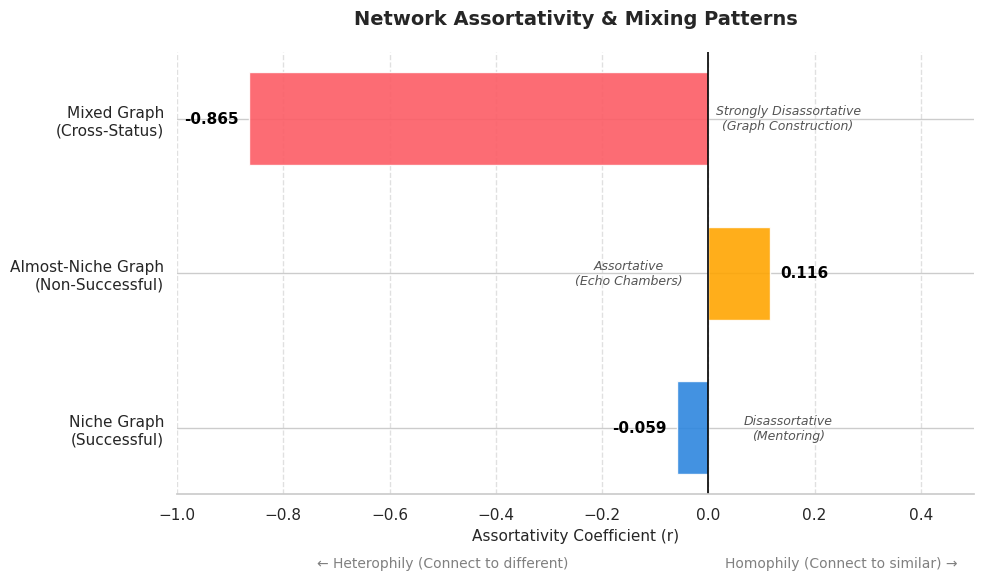

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Impostazioni stile
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 1. Preparazione Dati
data = {
    'Graph': ['Niche Graph\n(Successful)', 'Almost-Niche Graph\n(Non-Successful)', 'Mixed Graph\n(Cross-Status)'],
    'Value': [-0.059, 0.116, -0.865],
    'Type': ['Degree Assortativity', 'Degree Assortativity', 'Attribute Assortativity'],
    'Interpretation': ['Disassortative\n(Mentoring)', 'Assortative\n(Echo Chambers)', 'Strongly Disassortative\n(Graph Construction)']
}

df = pd.DataFrame(data)

# Colori coerenti con i grafici precedenti (Blu=Success, Arancio=Non-Success, Rosso=Mixed)
colors = ['#2E86DE', '#FFA502', '#FC5C65']

# 2. Creazione Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Disegno le barre orizzontali
bars = ax.barh(df['Graph'], df['Value'], color=colors, height=0.6, alpha=0.9)

# 3. Linea dello Zero e Zone
ax.axvline(0, color='black', linewidth=1.2, linestyle='-')
ax.set_xlim(-1.0, 0.5)  # Limiti asse X (da -1 a +0.5 per dare spazio)

# 4. Aggiunta Etichette Valori e Interpretazione
for bar, value, interp in zip(bars, df['Value'], df['Interpretation']):
    width = bar.get_width()

    # Posizionamento del testo del valore
    if value < 0:
        align = 'right'
        offset = -0.02
        text_color = 'black'
    else:
        align = 'left'
        offset = 0.02
        text_color = 'black'

    # Etichetta numerica (es. -0.059)
    ax.text(value + offset, bar.get_y() + bar.get_height()/2,
            f'{value:.3f}',
            va='center', ha=align, fontweight='bold', fontsize=11, color=text_color)

    # Etichetta interpretativa (es. "Mentoring")
    # La posiziono all'interno del grafico o a lato a seconda dello spazio
    interp_pos = -0.15 if value > 0 else 0.15
    ax.text(interp_pos, bar.get_y() + bar.get_height()/2,
            interp,
            va='center', ha='center', fontsize=9, style='italic', color='#555555')

# 5. Decorazioni Grafiche
# Aggiungo frecce o testi per spiegare l'asse X
ax.text(-0.5, -0.9, '← Heterophily (Connect to different)', ha='center', fontsize=10, color='gray')
ax.text(0.25, -0.9, 'Homophily (Connect to similar) →', ha='center', fontsize=10, color='gray')

ax.set_title('Network Assortativity & Mixing Patterns', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Assortativity Coefficient (r)', fontsize=11)
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Rimuovo bordi inutili
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.savefig('assortativity_plot.svg') # Decommenta per salvare
plt.show()

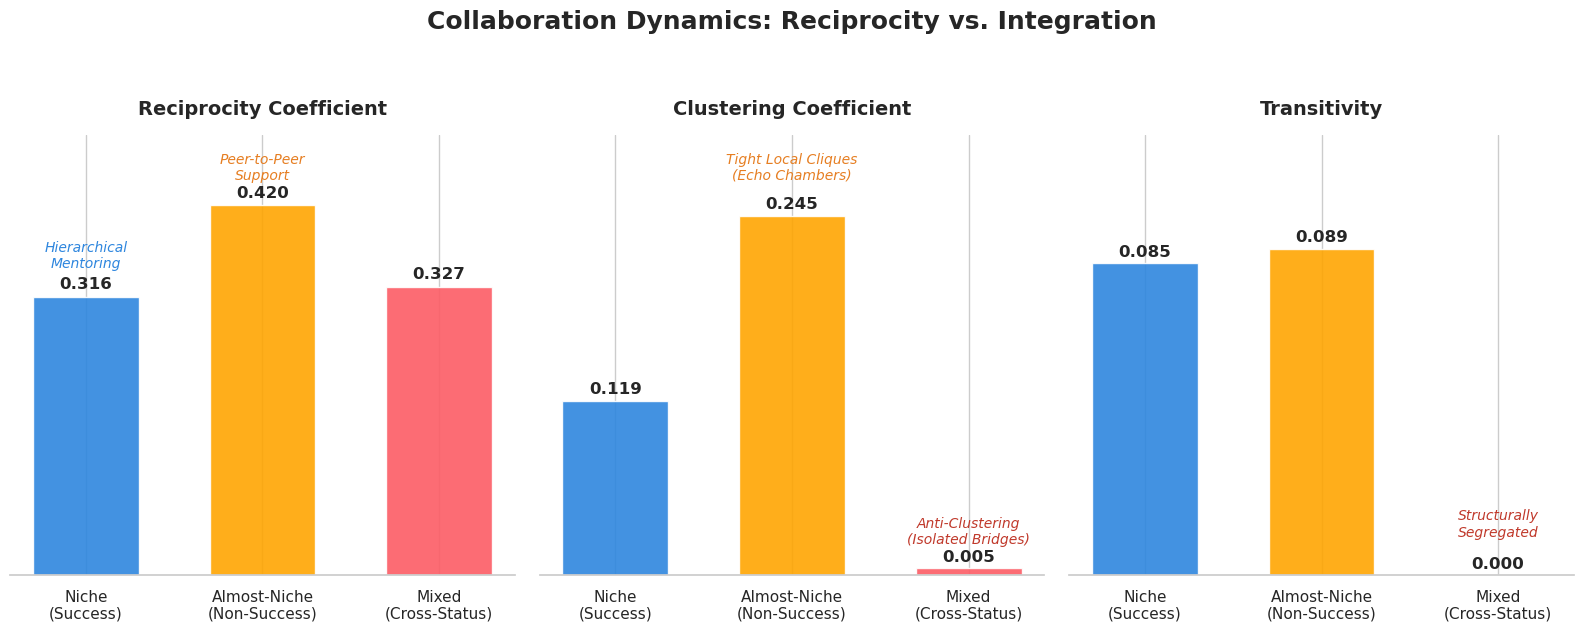

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Impostazioni stile
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Dati estratti dal tuo testo
graphs = ['Niche\n(Success)', 'Almost-Niche\n(Non-Success)', 'Mixed\n(Cross-Status)']
colors = ['#2E86DE', '#FFA502', '#FC5C65'] # Blu, Arancio, Rosso

# Valori
reciprocity = [0.316, 0.420, 0.327]
clustering = [0.119, 0.245, 0.005] # 0.005 visuale per il mixed (quasi zero)
transitivity = [0.085, 0.089, 0.000]

# Creazione della figura con 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# --- PLOT 1: RECIPROCITY ---
ax1 = axes[0]
bars1 = ax1.bar(graphs, reciprocity, color=colors, alpha=0.9, width=0.6)
ax1.set_title('Reciprocity Coefficient', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylim(0, 0.5)

# Annotazioni specifiche per Reciprocity
for i, (bar, val) in enumerate(zip(bars1, reciprocity)):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}',
             ha='center', fontweight='bold')

# Interpretazione (dal tuo testo)
ax1.text(0, 0.35, "Hierarchical\nMentoring", ha='center', color='#2E86DE', fontsize=10, style='italic')
ax1.text(1, 0.45, "Peer-to-Peer\nSupport", ha='center', color='#E67E22', fontsize=10, style='italic')

# --- PLOT 2: CLUSTERING ---
ax2 = axes[1]
bars2 = ax2.bar(graphs, clustering, color=colors, alpha=0.9, width=0.6)
ax2.set_title('Clustering Coefficient', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylim(0, 0.3)

# Annotazioni
for i, (bar, val) in enumerate(zip(bars2, clustering)):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.3f}',
             ha='center', fontweight='bold')

# Interpretazione
ax2.text(1, 0.27, "Tight Local Cliques\n(Echo Chambers)", ha='center', color='#E67E22', fontsize=10, style='italic')
ax2.text(2, 0.02, "Anti-Clustering\n(Isolated Bridges)", ha='center', va='bottom', color='#C0392B', fontsize=10, style='italic')

# --- PLOT 3: TRANSITIVITY ---
ax3 = axes[2]
bars3 = ax3.bar(graphs, transitivity, color=colors, alpha=0.9, width=0.6)
ax3.set_title('Transitivity', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylim(0, 0.12)

# Annotazioni
for i, (bar, val) in enumerate(zip(bars3, transitivity)):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.002, f'{val:.3f}',
             ha='center', fontweight='bold')

# Interpretazione
ax3.text(2, 0.01, "Structurally\nSegregated", ha='center', va='bottom', color='#C0392B', fontsize=10, style='italic')


# Pulizia finale
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    sns.despine(ax=ax, left=True)
    ax.set_yticks([]) # Rimuovo i numeri sull'asse Y per pulizia (i valori sono sulle barre)

plt.suptitle('Collaboration Dynamics: Reciprocity vs. Integration', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('collaboration_metrics.svg', bbox_inches='tight')
plt.show()

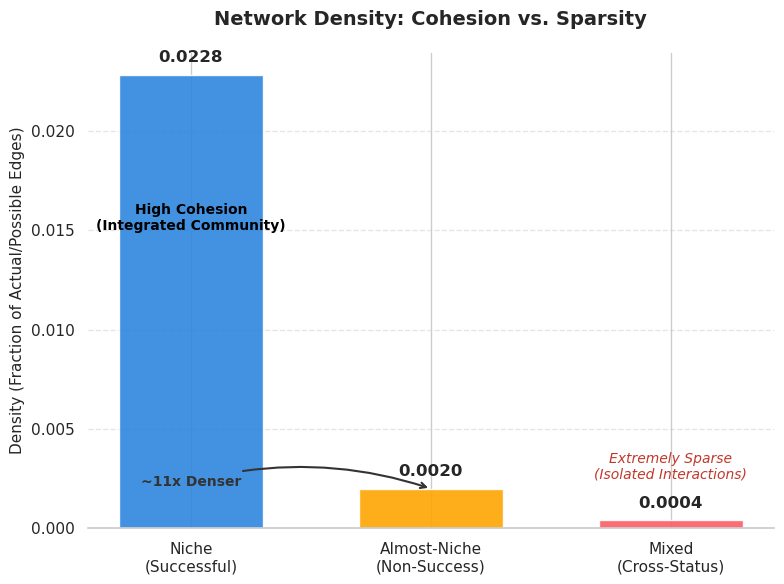

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Impostazioni stile
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Dati
graphs = ['Niche\n(Successful)', 'Almost-Niche\n(Non-Success)', 'Mixed\n(Cross-Status)']
density = [0.0228, 0.0020, 0.0004]
colors = ['#2E86DE', '#FFA502', '#FC5C65']

# Creazione Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Disegno le barre
bars = ax.bar(graphs, density, color=colors, width=0.6, alpha=0.9)

# Aggiungo i valori sopra le barre
for bar, val in zip(bars, density):
    height = bar.get_height()
    # Formattazione diversa per il valore molto piccolo
    label = f'{val:.4f}'

    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            label,
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# --- Annotazioni Strategiche ---

# 1. Freccia per indicare il "10x"
# Coordinate barre: 0 (Niche), 1 (Almost-Niche)
ax.annotate('~11x Denser',
            xy=(1, 0.0020), xycoords='data',
            xytext=(0, 0.0020), textcoords='data',
            arrowprops=dict(arrowstyle="->", color='#333333', lw=1.5, connectionstyle="arc3,rad=-0.15"),
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

# 2. Testo esplicativo per il Mixed Graph
ax.text(2, 0.0025, "Extremely Sparse\n(Isolated Interactions)",
        ha='center', color='#C0392B', fontsize=10, style='italic')

# 3. Testo esplicativo per il Niche Graph
ax.text(0, 0.015, "High Cohesion\n(Integrated Community)",
        ha='center', color='black', fontsize=10, fontweight='bold')

# Titoli e Label
ax.set_title('Network Density: Cohesion vs. Sparsity', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Density (Fraction of Actual/Possible Edges)', fontsize=11)

# Rimuovo bordi
sns.despine(left=True)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('network_density.svg')
plt.show()